Getting rid of Noise


68,2% Werte sammeln für mehrere IDs

Daraus dann Verteilung - Histogram - Gauß Fitt?

Ist globaler wert repräsentativ?

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import csv 
import numpy as np
import scipy.optimize as opt
import array
from itertools import combinations

In [83]:

def create_dataframe(file_path):
    """
    Reads in a csv file and creates a header and a data section

    Args:
        file_path (str): a relative or abolute pathway to the file, which contains the whole information

    Returns:
        header_section (list): list with each line of the header as an entry
        data_section_raw (dataframe): pandas dataframe of the data section

    """

    with open(file_path, 'r') as csv_file:
        data = csv.reader(csv_file, delimiter=',')

        header_section = []
        column_names = ["ID","Frame index","Groups","Donor Photons","Acceptor Photons","FRET efficiency","X (nm)","Y (nm)"]
        #nicht so sauber
        data_section_raw = pd.DataFrame(columns = column_names)

        #for row in data:
            #print(row)

        for n, row in enumerate(data):
            if n < 15:
            #das mit 15 ist unsauber
                header_section.append(row)
            elif n == 15:
                continue
            elif row == ['', '', '', '', '', '', '', '']:
                continue
            else:
                new_row=[]
                for element in row:
                        try:
                            new_row.append(float(element))
                        except ValueError:
                            new_row.append(0)

                data_section_raw.loc[n]=new_row

    return header_section, data_section_raw


In [84]:
def haar_cyles (dataframe, number_cycles):

    # FRET Werte aus Dataframe in eine lange Liste geben 

    FRET_list = []
    for element in dataframe["FRET efficiency"]:
        FRET_list.append(element)

    # Je ein Dict erstellen - Mit je zwei Werten und Mittelwert - 1 lange liste mit Dicts
        # Wenn einer der Werte 0 - überspringen
        # Wenn einer der Werte aus neuer ID - überspringen (noch nicht implementiert)

    new_list = []

    for number, element in enumerate(FRET_list):
        if number % 2 == 0:
            continue
        
        new_dict = {"First": FRET_list[number-1] ,"Second": FRET_list[number], "Mean": (FRET_list[number]+FRET_list[number-1])/2}
        
        if new_dict["First"] != 0 and new_dict["Second"] != 0:
            new_list.append(new_dict)

    #print(new_list)

    # Pro Zyklus: (0 Zyklen = überspringen)
        # Von zwei Dicts hintereinander die Mittelwerte als Werte für neues Dict
        # Mittelwert dieser berechnen und ebenfalls in Dict
        # Belieblig oft wiederholen

    while number_cycles > 0:

        iter_list = new_list.copy()
        new_list = []

        #print("____________________________________________")
        #print("One cycle happend")
        #print("____________________________________________")

        for number, element in enumerate(iter_list):

            try:

                if number % 2 == 0:
                    continue
        
                new_dict = {"First": iter_list[number-1]["Mean"] ,"Second": iter_list[number]["Mean"], "Mean": (iter_list[number]["Mean"]+iter_list[number-1]["Mean"])/2}
                new_list.append(new_dict)
                
            except IndexError:
                continue

        number_cycles = number_cycles - 1

        #print (new_list)

    # Abweichung von Werten zu  Mittelwert berechnen
    # Diese Abweichung in Liste geben

    noises = []

    for element in new_list:
        noise = element["Mean"] - element["First"]
        noises.append(abs(noise))
        #noises.append(noise)

    # print("\n-------------------------------\n")
    # print("List of noises")
    # print(noises)

    return noises

In [85]:
def histogram_fit (noises, binsize, cutoff = 68.2):

    y_values, bin_edges, third_variable = plt.hist(noises, binsize)
    
    bin_edges_list = []

    for element in bin_edges:
        bin_edges_list.append(element)


    bin_width = (bin_edges_list[1] - bin_edges_list [0])

    x_values = []

    for element in bin_edges_list:
        current_value = element + bin_width/2
        x_values.append(current_value)

    x_values.pop()
    # Letzter Wert muss weg weil letzte Bin-Grenze + 1/2 Binsize keinem Datenpunkt entspricht!

    plt.scatter(x_values, y_values, c = "red")
    #plt.figure(figsize=(50, 100), dpi = 80)
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.show

    y_values_cumu = []
    current_value = 0

    for element in y_values:
        current_value += element
        y_values_cumu.append(current_value)

    #print(y_values_cumu)

    plt.scatter(x_values, y_values_cumu, c = "green")
    plt.show

    hundred_percent = y_values_cumu[-1]
    value_crit = hundred_percent * cutoff/100

    print(f"The value at {cutoff}% is {value_crit}")

    plt.axhline(y=value_crit, color="yellow", linestyle='-')
    plt.show

    y_values_cumu = array.array("f", y_values_cumu)
    #?????????????????????????????????????????

    return y_values, y_values_cumu, x_values, value_crit



In [86]:
def gaussian_curve_fit (x_values, y_values):

    # das unterhalb funktioniert nur wenn die y-werte arrays sind!
    # y values ist array, aber y values cumu ist liste!

    #y_values = array.array("f", y_values)

    print(y_values)
    print(type(y_values))

    random_list = [4,2,6,2,7,7,5,3,2,5,6,3]

    random_array = array.array("f", random_list)
    print(random_array)
    print(type(random_array))

    # random_numpy = np.ndarray(shape = (),dtype = float, buffer = random_list)
    # print(random_numpy)


    #Dieser Teil derzeit nur Copy Paste!

    n = len(x_values)                         
    mean = sum(x_values*y_values)/n                  
    sigma = sum(y_values*(x_values-mean)**2)/n 

    def gauss_function(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
        # a = height of the curves peak
        # x0 = position of center of peak
        # sigma = controlls the width of the "bell"
        
    popt,pcov = opt.curve_fit(f = gauss_function, xdata = x_values, ydata = y_values, p0=[1,mean,sigma])
    #Gauß fittet nicht nur sigma sondern auch müh etc!
    #sigma zuvor zwar "richtiger" aber "blind" für alles andere

    plt.plot(x_values,y_values,'b+:',label='data')
    plt.plot(x_values,gauss_function(x_values,*popt),'ro:',label='fit')
    plt.legend()
    plt.title('Titel')
    plt.xlabel('x label')
    plt.ylabel('y label')
    plt.show()

    
    print("popt: letzter der drei Werte ist Sigma")
    print(popt)
    print("simga 2:")
    print(sigma)

The value at 68.2% is 24.552000000000003
[10.  5.  7.  7.  3.  1.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.]
<class 'numpy.ndarray'>
array('f', [4.0, 2.0, 6.0, 2.0, 7.0, 7.0, 5.0, 3.0, 2.0, 5.0, 6.0, 3.0])
<class 'array.array'>


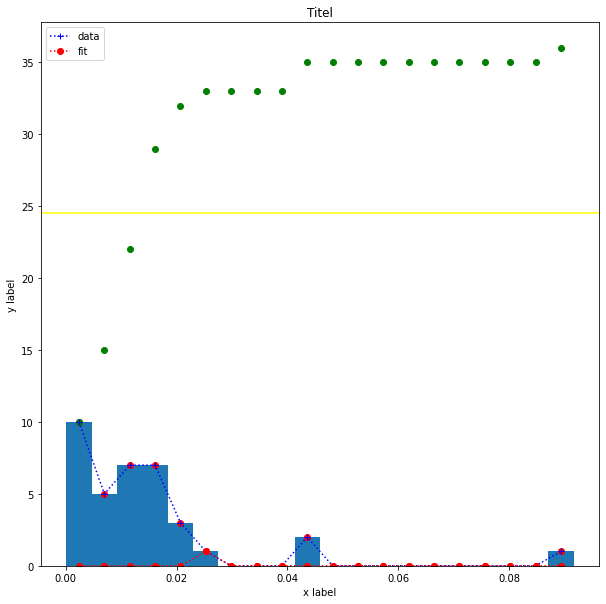

popt: letzter der drei Werte ist Sigma
[1.03766322e+00 2.54805988e-02 7.74827023e-04]
simga 2:
0.0007041394310926874
simga 3:
24.552000000000003
Problem letzter Wert - ich bräucht x wert dazu + es hängt vom fehleranfälligen maximalwert ab


In [87]:

#header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding only 2 IDs.csv")
#header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding.csv")
header, dataframe = create_dataframe("./dsDNA_FRETtraces_examples_MK_bearbeitet_ID438.csv")

#print(dataframe)

noises = haar_cyles(dataframe,2)

y_values, y_values_cumu, x_values, value_crit = histogram_fit(noises, 20)

test = gaussian_curve_fit (x_values, y_values)
#test = gaussian_curve_fit (x_values, y_values_cumu)
print("simga 3:")
print(value_crit)
print("Problem letzter Wert - ich bräucht x wert dazu + es hängt vom fehleranfälligen maximalwert ab")


In [88]:

#______________________________________________________________________________________________________

# Für jeden Punkt:

# (durchschnitt der werte nach dem punkt - durchschnitt der werte vor dem punkt)/sigma*(((1/i)+(1/(N-i)))**0.5)

def find_transition_points(liste_y, sigma, transition_search_loops, transition_treshold):

    print("___________________________________________________")
    print("FIND TRANSITION POINTS")
    print("___________________________________________________")

    liste_x = []
    number = 1
    while number < len(liste_y)+1:
        liste_x.append(number)
        number += 1

    transition_points = [{"index": 0, "value": 0}]
    sigma = 2

    number = 0

    print(len(liste_y))

    #while len(transition_points) < 4
    while number < transition_search_loops:

        print("NEW ROUND---------------------------------------------")

        candidates_for_transition = []

        for i,transition_point in enumerate(transition_points):
            start = transition_points[i]["index"]
            print("START:")
            print(start)

            try:
                end = transition_points[i+1]["index"]
            except IndexError:
                end = -1

            print("END")
            print(end)

            current_list = liste_y[start:end]
            #print(current_list)

            values = []

            for index, element in enumerate (current_list):

                try:
                    one_by_N_minus_i = 1/(len(current_list)-index)
                except ZeroDivisionError:
                    one_by_N_minus_i = 0

                try:
                    one_by_i = 1/index
                except ZeroDivisionError:
                    one_by_i = 0

                try:
                    average_before = sum(current_list[0:index])/len(current_list[0:index])
                except ZeroDivisionError:
                    average_before = 0
                try:
                    average_after = sum(current_list[index:-1])/len(current_list[index:-1])
                except ZeroDivisionError:
                    average_after = 0

                numerator = average_after - average_before
                denominator = sigma*((one_by_N_minus_i+ one_by_i)**0.5)
                value = numerator/denominator
                values.append(value)

            #print(values)

            plt.plot(liste_x[start:end], values)

            try:
                max_value = max(values[1:], key=abs)
            except ValueError:
                continue
            print("MAX VALUE:")
            print(max_value)
            max_index_local = values.index(max_value)
            max_index_global = max_index_local + start
            print("MAX INDEX GLOBAL:")
            print(max_index_global)
            max_dict = {"index": max_index_global , "value": abs(max_value)}
            candidates_for_transition.append(max_dict)

        print("candidates_for_transition:")
        print(candidates_for_transition)

        max_candidate = max(candidates_for_transition,  key=lambda x:x["value"])
        max_transitions = max(transition_points, key=lambda x:x["value"])

        # max_candidate = max(item["value"] for item in candidates_for_transition)
        # max_transitions = max(item["value"] for item in transition_points)

        if max_candidate["value"] > max_transitions["value"]*transition_treshold:
            transition_points.append(max_candidate)
        else:
            print("Value rejectedXXXXXXXXXXXXXXXXXXXXXXX")


        # transition_points.append(max_candidate)

        number = number + 1

    print(transition_points)


    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    plt.plot(liste_x[1:], liste_y[1:])
    #plt.plot(liste_x[1:], values[1:])

    for element in transition_points:
        plt.axvline(x = element["index"], color="black", linestyle='-')

    plt.axhline(y = 0, color="black", linestyle='-')

    plt.show()

    return transition_points

#_________________________________________________________________________________________________________


# x_array = np.array(liste_x,dtype = np.int)
# y_array = np.array(values, dtype = np.float)
# slope = np.diff(y_array)/np.diff(x_array)

# print (slope)
# print(np.diff(slope))

# plt.plot(liste_x[2:-1], slope[2:])
# plt.plot(liste_x[2:-2], np.diff(slope[2:]))

#_________________________________________________________________________________________________________



# von values höchsten absolut wert finden
# den dazugehörigen x wert in transition point liste speichern 
# dann die liste der y werte teilen an diesem punkt
# für die zwei listen nun wieder values berechnen
# den höchsten der beiden werte (absolut) nun wieder in transition points abspeichern
# diese liste wieder spalten
# mal ein while loop mit bestimmten wiederholungen, sonst vl mit statsistischem tool?



#20:30 - 22:15 - 
#0:15 - 02:30

 

In [89]:
def find_levels(liste_y, transition_points, blending_cycles, max_diff):

    print("___________________________________________________")
    print("FIND LEVELS")
    print("___________________________________________________")

    
    means = []

    liste_x = []
    number = 1
    while number < len(liste_y)+1:
        liste_x.append(number)
        number += 1

    plt.plot(liste_x[1:], liste_y[1:])

    for i,transition_point in enumerate(transition_points):
        start = transition_points[i]["index"]
        print("START:")
        print(start)

        try:
            end = transition_points[i+1]["index"]
        except IndexError:
            end = -1

        print("END")
        print(end)

        current_list = liste_y[start:end]

        try:
            current_mean = sum(current_list)/len(current_list)
        except ZeroDivisionError:
            continue
        
        means.append({"mean": current_mean, "start": start, "end": end})

        if end != -1:
            plt.plot((start, end), (current_mean, current_mean), 1)
        else:
            plt.plot((start, max(liste_x)), (current_mean, current_mean), 1)

    print ("MEANS:")
    print(means)

    plt.show()

    binsize = 20

    means_for_histo = []
    for element in means:
        means_for_histo.append(element["mean"])

    lol = histogram_fit (means_for_histo, binsize, cutoff = 68.2)
    plt.show()

    number_of_cycles = 0

    while number_of_cycles < blending_cycles:

        print ("___________________________________________________________________________________")
        print(f"Blending Cycle Nr. {number_of_cycles+1}")
        print ("___________________________________________________________________________________")
        
        pairings = []
        temp = combinations(means, 2)
        for element in list(temp):
            current_diff = element[0]["mean"]-element[1]["mean"]
            pairings.append({"elements": element, "diff": abs(current_diff)})
            
        print("pairings:")
        print(pairings)

        # min_diff = min(pairings, key=lambda x:x["diff"])

        #[{'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.476190476190476, 'start': 41, 'end': 62}), 
        #'diff': 4.915214866434379}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 2.0, 'start': 62, 'end': 80}), 'diff': 0.5609756097560976}, 

        current_min = 0

        for index, _ in enumerate(pairings):
            if pairings[index - 1]["diff"] > 0:
                current_min = pairings[index - 1]["diff"]
                min_diff = pairings[index - 1]
                print(f"New curren min is {current_min}")

        if current_min == 0:
            print ("THERE IS ONLY ONE MEAN VALUE LEFT")
            break

        for element in pairings:
            if element["diff"] > 0 and element["diff"] < current_min:
                current_min = element["diff"]
                min_diff = element

        print("min_diff")
        print(min_diff)

        if min_diff["diff"] > max_diff:
            print(f"The current difference of {min_diff['diff']} is higher than the maximal difference parameter of {max_diff}")
            break

        combine_values_1 = min_diff["elements"][0]["start"]
        combine_values_2 = min_diff["elements"][1]["start"]
        new_value = (min_diff["elements"][0]["mean"] + min_diff["elements"][1]["mean"])/2

        to_be_counified_values_1 = min_diff["elements"][0]["mean"]
        to_be_counified_values_2 = min_diff["elements"][1]["mean"]

        #{'elements': ({'mean': 7.476190476190476, 'start': 41}, {'mean': 7.375, 'start': 80}), 'diff': 0.10119047619047628}

        print("combine_values_1:")    
        print(combine_values_1)

        print("combine_values_2:")    
        print(combine_values_2)

        #MEANS:
        #[{'mean': 2.5609756097560976, 'start': 0}, {'mean': 7.476190476190476, 'start': 41}, {'mean': 2.0, 'start': 62}, {'mean': 7.375, 'start': 80}, {'mean': 1.8, 'start': 88}]

        print("MEAN BEFORE:")
        print(means)

        for element in means:
            if element["start"] == combine_values_1 or element["start"] == combine_values_2:
                element["mean"] = new_value
            if element["mean"] == to_be_counified_values_1 or element["mean"] == to_be_counified_values_2:
                element["mean"] = new_value
                
        print("MEANS AFTER")
        print(means)

        plt.plot(liste_x[1:], liste_y[1:])
        
        for element in means:
            if element["end"] != -1:
                plt.plot((element["start"], element["end"]), (element["mean"], element["mean"]), 1)
            else:
                plt.plot((element["start"], max(liste_x)), (element["mean"], element["mean"]), 1)


        #[{'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 41, 'end': 62}, 
        #{'mean': 2.0, 'start': 62, 'end': 80}, {'mean': 7.425595238095238, 'start': 80, 'end': 88}, {'mean': 1.8, 'start': 88, 'end': -1}]        

        vertical_lines = []
        for element in transition_points:
            vertical_lines.append({"x": element["index"], "y_1": 0, "y_2":0 })

        for element in vertical_lines:
            for item in means:
                if item["start"] == element ["x"]:
                    element["y_2"] = item["mean"]
                if item["end"] == element ["x"]:
                    element["y_1"] = item["mean"]


        print("vertical_lines:")
        print(vertical_lines)

        for element in vertical_lines:
            if element ["x"] != 0:
                plt.plot((element["x"], element["x"]), (element["y_1"], element["y_2"]), 1)

        plt.show()

        number_of_cycles = number_of_cycles + 1


    #13:30 - xxxx


___________________________________________________
FIND TRANSITION POINTS
___________________________________________________
99
NEW ROUND---------------------------------------------
START:
0
END
-1
MAX VALUE:
5.475670806764653
MAX INDEX GLOBAL:
41
candidates_for_transition:
[{'index': 41, 'value': 5.475670806764653}]
NEW ROUND---------------------------------------------
START:
0
END
41
MAX VALUE:
-1.2717018556863469
MAX INDEX GLOBAL:
40
START:
41
END
-1
MAX VALUE:
-7.786647526326598
MAX INDEX GLOBAL:
62
candidates_for_transition:
[{'index': 40, 'value': 1.2717018556863469}, {'index': 62, 'value': 7.786647526326598}]
NEW ROUND---------------------------------------------
START:
0
END
41
MAX VALUE:
-1.2717018556863469
MAX INDEX GLOBAL:
40
START:
41
END
62
MAX VALUE:
-3.659625273556999
MAX INDEX GLOBAL:
61
START:
62
END
-1
MAX VALUE:
3.7058823529411766
MAX INDEX GLOBAL:
80
candidates_for_transition:
[{'index': 40, 'value': 1.2717018556863469}, {'index': 61, 'value': 3.659625273556999}

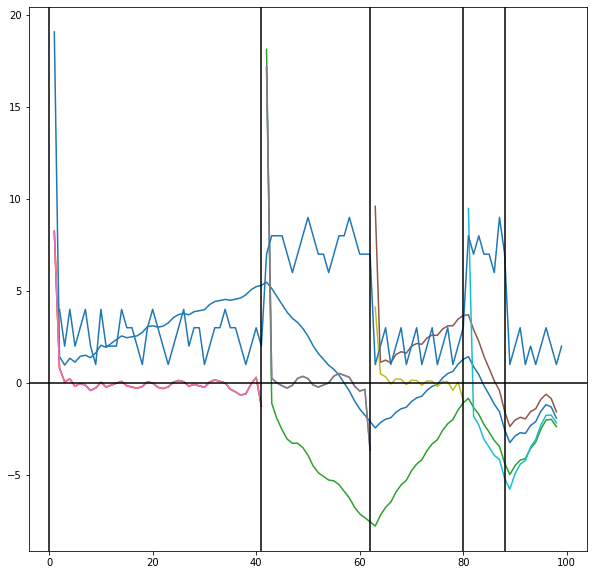

___________________________________________________
FIND LEVELS
___________________________________________________
START:
0
END
41
START:
41
END
62
START:
62
END
80
START:
80
END
88
START:
88
END
-1
MEANS:
[{'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.476190476190476, 'start': 41, 'end': 62}, {'mean': 2.0, 'start': 62, 'end': 80}, {'mean': 7.375, 'start': 80, 'end': 88}, {'mean': 1.8, 'start': 88, 'end': -1}]


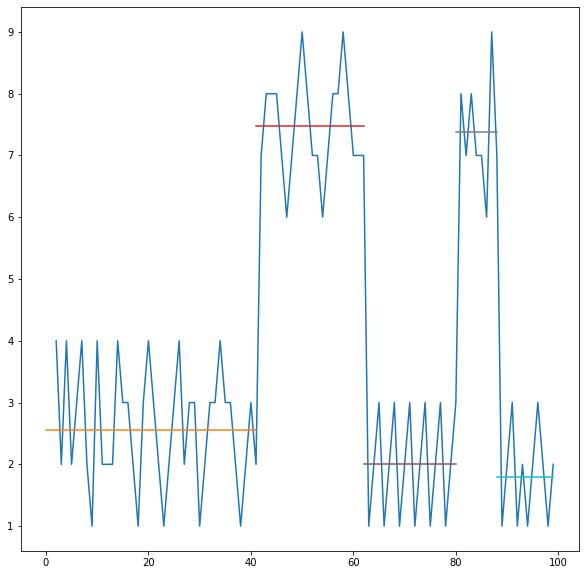

The value at 68.2% is 3.41


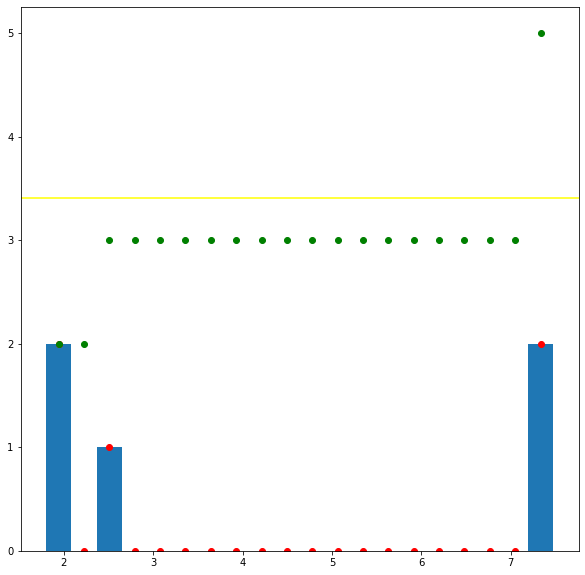

___________________________________________________________________________________
Blending Cycle Nr. 1
___________________________________________________________________________________
pairings:
[{'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.476190476190476, 'start': 41, 'end': 62}), 'diff': 4.915214866434379}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 2.0, 'start': 62, 'end': 80}), 'diff': 0.5609756097560976}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.375, 'start': 80, 'end': 88}), 'diff': 4.814024390243903}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 1.8, 'start': 88, 'end': -1}), 'diff': 0.7609756097560976}, {'elements': ({'mean': 7.476190476190476, 'start': 41, 'end': 62}, {'mean': 2.0, 'start': 62, 'end': 80}), 'diff': 5.476190476190476}, {'elements': ({'mean': 7.476190476190476, 'start': 41, 'end': 62}, {'mean': 7.375, 'start': 80, 'end': 88})

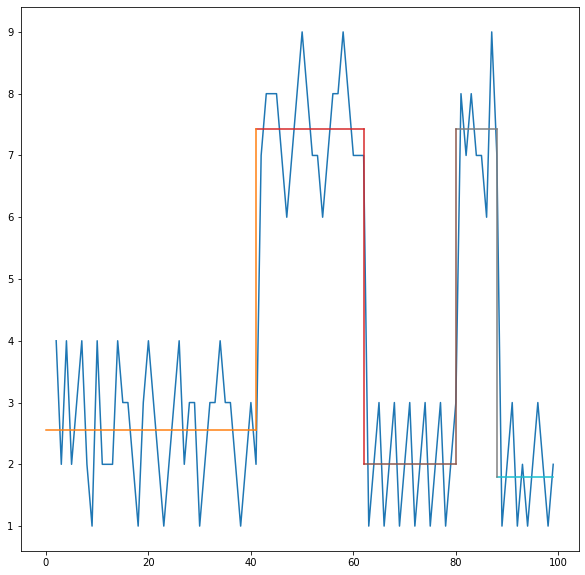

___________________________________________________________________________________
Blending Cycle Nr. 2
___________________________________________________________________________________
pairings:
[{'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 41, 'end': 62}), 'diff': 4.86461962833914}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 2.0, 'start': 62, 'end': 80}), 'diff': 0.5609756097560976}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 80, 'end': 88}), 'diff': 4.86461962833914}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 1.8, 'start': 88, 'end': -1}), 'diff': 0.7609756097560976}, {'elements': ({'mean': 7.425595238095238, 'start': 41, 'end': 62}, {'mean': 2.0, 'start': 62, 'end': 80}), 'diff': 5.425595238095238}, {'elements': ({'mean': 7.425595238095238, 'start': 41, 'end': 62}, {'mean': 7.425595238095238, 's

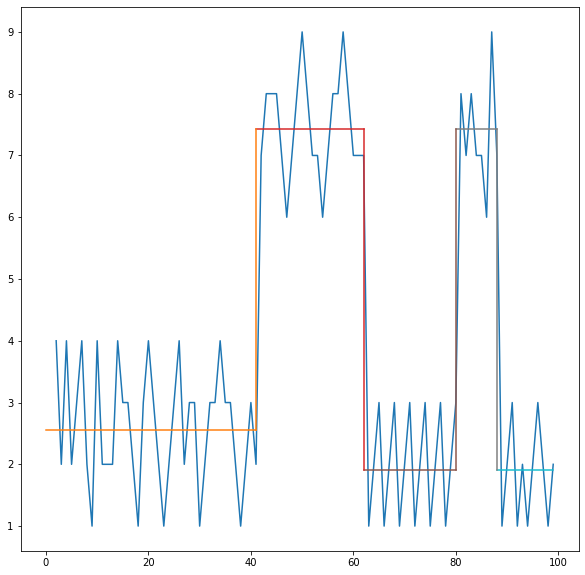

___________________________________________________________________________________
Blending Cycle Nr. 3
___________________________________________________________________________________
pairings:
[{'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 41, 'end': 62}), 'diff': 4.86461962833914}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 1.9, 'start': 62, 'end': 80}), 'diff': 0.6609756097560977}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 80, 'end': 88}), 'diff': 4.86461962833914}, {'elements': ({'mean': 2.5609756097560976, 'start': 0, 'end': 41}, {'mean': 1.9, 'start': 88, 'end': -1}), 'diff': 0.6609756097560977}, {'elements': ({'mean': 7.425595238095238, 'start': 41, 'end': 62}, {'mean': 1.9, 'start': 62, 'end': 80}), 'diff': 5.525595238095239}, {'elements': ({'mean': 7.425595238095238, 'start': 41, 'end': 62}, {'mean': 7.425595238095238, 's

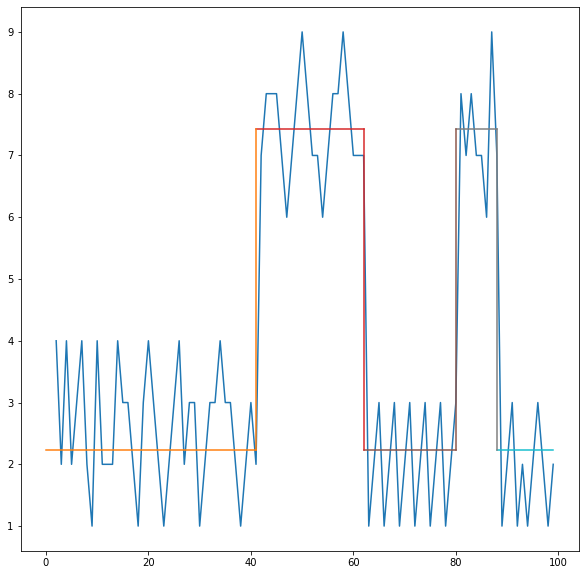

___________________________________________________________________________________
Blending Cycle Nr. 4
___________________________________________________________________________________
pairings:
[{'elements': ({'mean': 2.2304878048780488, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 41, 'end': 62}), 'diff': 5.195107433217189}, {'elements': ({'mean': 2.2304878048780488, 'start': 0, 'end': 41}, {'mean': 2.2304878048780488, 'start': 62, 'end': 80}), 'diff': 0.0}, {'elements': ({'mean': 2.2304878048780488, 'start': 0, 'end': 41}, {'mean': 7.425595238095238, 'start': 80, 'end': 88}), 'diff': 5.195107433217189}, {'elements': ({'mean': 2.2304878048780488, 'start': 0, 'end': 41}, {'mean': 2.2304878048780488, 'start': 88, 'end': -1}), 'diff': 0.0}, {'elements': ({'mean': 7.425595238095238, 'start': 41, 'end': 62}, {'mean': 2.2304878048780488, 'start': 62, 'end': 80}), 'diff': 5.195107433217189}, {'elements': ({'mean': 7.425595238095238, 'start': 41, 'end': 62}, {'mean': 7.42

In [90]:
# T-Test

#Probeliste:

liste_y = [1,4,2,4,2,3,4,2,1,4,2,2,2,4,3,3,2,1,3,4,3,2,1,2,3,4,2,3,3,1,2,3,3,4,3,3,2,1,2,3,2,7,8,8,8,7,6,7,8,9,8,7,7,6,7,8,8,9,8,7,7,7,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,8,7,8,7,7,6,9,7,1,2,3,1,2,1,2,3,2,1,2,]
#liste_y = [1,2,4,5,3,1,4,1,2,4,4,6,5,1,2,1,2,3,4,5,6,4,4,1,2,2,3,4,1,2,7,9,9,7,6,7,8,1,2,4,5,2,1,2,4,1,5,6,7,5,4,5,6,3,2,5,6,3,3,4,5,2,2,3,3,2]

#header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding only 2 IDs.csv")
#header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding only 1 ID.csv")
#header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding.csv")

#header, dataframe = create_dataframe("./dsDNA_FRETtraces_examples_MK_bearbeitet_ID438.csv")

# liste_y = []
# for element in dataframe["FRET efficiency"]:
#     liste_y.append(element)

#liste_y = liste_y[400:900]

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#transition_search_loops = 2
transition_search_loops = 4
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

transition_treshold = 0.2
sigma = 2

transition_points = find_transition_points(liste_y, sigma, transition_search_loops, transition_treshold)

blending_cycles = 6


#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_diff = 1
#max_diff = 10
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


test = find_levels(liste_y, transition_points, blending_cycles, max_diff)


